# 1. Carga de datos y preparación

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset
df = pd.read_csv("/content/drive/MyDrive/Dataset´s/weather_data.csv")

# Convertir la columna de fecha a formato datetime
df['dt_txt'] = pd.to_datetime(df['dt_txt'])

df = df.sample(n=10000, random_state=42)  # Seleccionar 100,000 filas al azar

# Filtrar las columnas relevantes
df = df[['dt_txt', 'temp_max', 'humidity', 'wind_speed']]

# Crear etiqueta de onda de calor (temperatura máxima > 35°C durante 3 días consecutivos)
threshold = 35  # Umbral de temperatura para onda de calor
df['heat_wave'] = (df['temp_max'] > threshold).astype(int)
df['heat_wave'] = df['heat_wave'].rolling(window=3).sum().shift(-2).fillna(0).astype(int)


# 2. Escalado de los datos

In [17]:
# Normalización de las columnas
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[['temp_max', 'humidity', 'wind_speed']] = scaler.fit_transform(df[['temp_max', 'humidity', 'wind_speed']])

# 3. Preparación de secuencias

In [18]:
import numpy as np

# Crear secuencias de datos (X) y etiquetas (y)
sequence_length = 30  # Número de días por secuencia

def create_sequences(df, sequence_length):
    sequences = []
    labels = []

    for i in range(len(df) - sequence_length):
        sequence = df.iloc[i:i+sequence_length][['temp_max', 'humidity', 'wind_speed']].values
        label = df.iloc[i+sequence_length]['heat_wave']

        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

X, y = create_sequences(df_scaled, sequence_length)

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Modelo LSTM

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Para clasificación binaria

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7160 - loss: 0.6280 - val_accuracy: 0.7367 - val_loss: 0.6038
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7370 - loss: 0.6075 - val_accuracy: 0.7367 - val_loss: 0.6028
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7225 - loss: 0.6231 - val_accuracy: 0.7367 - val_loss: 0.6029
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7310 - loss: 0.6118 - val_accuracy: 0.7367 - val_loss: 0.6050
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7299 - loss: 0.6159 - val_accuracy: 0.7367 - val_loss: 0.6044
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7331 - loss: 0.6150 - val_accuracy: 0.7367 - val_loss: 0.6029
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.7320 - loss: 0.6125 - val_accuracy: 0.7367 - val_loss: 0.6046
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7317 - loss: 0.6119 - val_accuracy:

#5. Evaluación y visualización

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7003 - loss: 0.6406
Pérdida: 0.6066240072250366, Precisión: 0.7367101311683655


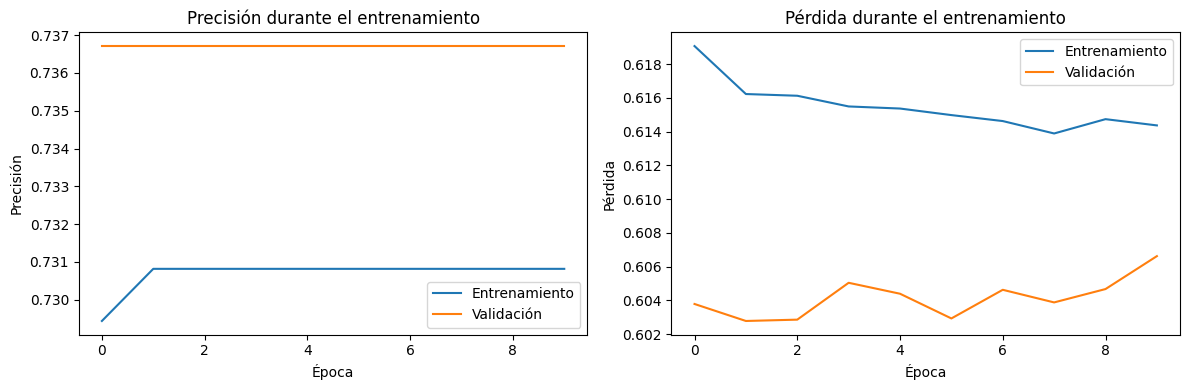

In [20]:
import matplotlib.pyplot as plt

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida: {loss}, Precisión: {accuracy}')

# Graficar la precisión y pérdida
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


## Precisión durante el entrenamiento:
* **Estancamiento temprano**: La precisión tanto en entrenamiento como en validación se mantiene prácticamente constante (entorno a 73.0%–73.7%) desde la primera época.

* **Posible problema**: Esto indica que el modelo no está aprendiendo más allá de las primeras épocas. Puede deberse a:

  * Un modelo poco complejo (necesita más capas o unidades).

  * Poca variabilidad informativa en los datos (features poco correlacionadas con el objetivo).

  * Necesidad de ajustar el learning rate u optimizador.

## Pérdida durante el entrenamiento:
* Pérdida de entrenamiento decrece lentamente, lo que puede ser bueno.

* Pérdida de validación se mantiene estable o incluso crece levemente, lo cual sugiere un pequeño overfitting, aunque muy leve.

* Ambas curvas están algo alejadas, lo que también podría señalar que el modelo generaliza moderadamente, pero no de forma óptima.

## Posible mejora:
Podría gregar más variables predictoras (por ejemplo: presión, nubosidad, nivel del mar).

Experimentar con más épocas (20 o 50) para confirmar si realmente está estancado.